# SEP 775 Assignment 3

In [1]:
!pip install datasets transformers
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModel, AutoConfig, AutoTokenizer
import math
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import copy
import random
import gc

C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Importing Data for TANDA and EDA

In [2]:
ANSQ_train_df = pd.read_parquet('./ANSQ/train-00000-of-00008.parquet')
ANSQ_val_df = pd.read_parquet('./ANSQ/validation-00000-of-00001.parquet')

In [3]:
ANSQ_train_df.head()

,question,sentence,label,sentence_in_long_answer,short_answer_in_sentence
0,what is the use of fn key in mac,It is typically found on laptops due to their ...,0,False,False
1,when did the ipod 7th generation come out,"Cupertino , California : Apple .",0,False,False
2,who dies in season 6 once upon a time,"^ Jump up to : Abrams , Natalie ( August 5 , 2...",0,False,False
3,who was the first avatar ever in the last airb...,Jeremy Zuckerman and Benjamin Wynn composed th...,0,False,False
4,how many games do they need to win to win the ...,p. 21 .,0,False,False


In [4]:
ANSQ_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547196 entries, 0 to 2547195
Data columns (total 5 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   question                  object
 1   sentence                  object
 2   label                     int64 
 3   sentence_in_long_answer   bool  
 4   short_answer_in_sentence  bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 63.2+ MB


In [5]:
ANSQ_val_df.head()

,question,sentence,label,sentence_in_long_answer,short_answer_in_sentence
0,who issued gold coins for the first time in india,Jump up ^ `` Puranas or Punch - Marked Coins (...,0,False,False
1,most passing yards by nfl qb in a game,"71 : Kramer , Tommy Tommy Kramer 000000001985 ...",0,True,False
2,where does cortisol come from in the body,Psychoneuroendocrinology.,0,False,False
3,the rime of the ancient mariner albatross symb...,Contents ( hide ) 1 Film 2 Music 2.1 Musical 2...,0,False,False
4,who was it that described the structure of dna,If the DNA is twisted in the direction of the ...,0,False,False


In [6]:
ANSQ_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930062 entries, 0 to 930061
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   question                  930062 non-null  object
 1   sentence                  930062 non-null  object
 2   label                     930062 non-null  int64 
 3   sentence_in_long_answer   930062 non-null  bool  
 4   short_answer_in_sentence  930062 non-null  bool  
dtypes: bool(2), int64(1), object(2)
memory usage: 23.1+ MB


Obtain lengths (by the number of words splitted by space) of questions and sentences in ANSQ training and validation sets

In [7]:
ansq_train_q_len = [len(s.split()) for s in ANSQ_train_df['question']]
ansq_train_s_len = [len(s.split()) for s in ANSQ_train_df['sentence']]
ansq_val_q_len = [len(s.split()) for s in ANSQ_val_df['question']]
ansq_val_s_len = [len(s.split()) for s in ANSQ_val_df['sentence']]

Print the max length of ANSQ traning and validation questions, and the max and average lengths of ANSQ traning and validation sentences

In [8]:
print("Max length of ANSQ training set questions: %d"%max(ansq_train_q_len))
print("Max length of ANSQ training set sentences: %d"%max(ansq_train_s_len))
print("Max length of ANSQ validation set questions: %d"%max(ansq_val_q_len))
print("Max length of ANSQ validation set sentences: %d"%max(ansq_val_s_len))
print("Avg. length of ANSQ training set sentences: %d"%(sum(ansq_train_s_len)/len(ansq_train_s_len)))
print("Avg. length of ANSQ validation set sentences: %d"%(sum(ansq_val_s_len)/len(ansq_val_s_len)))

Max length of ANSQ training set questions: 21
Max length of ANSQ training set sentences: 18509
Max length of ANSQ validation set questions: 19
Max length of ANSQ validation set sentences: 18681
Avg. length of ANSQ training set sentences: 22
Avg. length of ANSQ validation set sentences: 22


The average length of sentences was 22 while the max lengths were tens of thousands. This implies that most of the sentences have length less than 20. The sample pairs with long sentences (e.g., when the length of concatenation of question sentence pair exceeding the input length limit of the pretrained Transformer model later will be used) could be discarded.

Obtain the number of question and sentence pairs with lable value 0/1 in ANSQ training and validation sets

In [9]:
ANSQ_train_df['label'].value_counts()

label
0    2539497
1       7699
Name: count, dtype: int64

In [10]:
ANSQ_val_df['label'].value_counts()

label
0    925776
1      4286
Name: count, dtype: int64

In [11]:
ANSQ_train_df[ANSQ_train_df['label']==1]['sentence_in_long_answer'].value_counts()

sentence_in_long_answer
True    7699
Name: count, dtype: int64

In [12]:
ANSQ_train_df[ANSQ_train_df['label']==1]['short_answer_in_sentence'].value_counts()

short_answer_in_sentence
True    7699
Name: count, dtype: int64

In [13]:
ANSQ_val_df[ANSQ_val_df['label']==1]['sentence_in_long_answer'].value_counts()

sentence_in_long_answer
True    4286
Name: count, dtype: int64

In [14]:
ANSQ_val_df[ANSQ_val_df['label']==1]['short_answer_in_sentence'].value_counts()

short_answer_in_sentence
True    4286
Name: count, dtype: int64

As shown above, all the ANSQ question and sentence pairs with label value 1 are True on both sentence\_in\_long\_answer and short\_answer\_in\_sentence

Perform similar analysis on TREC-QA dataset

In [15]:
TREC_train_df = pd.read_parquet('./TREC_QA/train-00000-of-00001-5853783192ac450d.parquet')
TREC_dev_df = pd.read_parquet('./TREC_QA/dev_clean-00000-of-00001-3add9aa872451476.parquet')
TREC_test_df = pd.read_parquet('./TREC_QA/test_clean-00000-of-00001-7a41400a142c05b2.parquet')

In [16]:
TREC_train_df.head()

,answer,question,key,label
0,the IRON LADY ; A Biography of Margaret Thatch...,"Who is the author of the book , `` The Iron La...",0,1
1,"in this same revisionist mold , Hugo Young , t...","Who is the author of the book , `` The Iron La...",0,1
2,"in `` The Iron Lady , '' Young traces the wind...","Who is the author of the book , `` The Iron La...",0,1
3,`` He is the very essence of the classless mer...,"Who is the author of the book , `` The Iron La...",0,1
4,"From her father , Young argues , she inherited...","Who is the author of the book , `` The Iron La...",0,0


In [17]:
TREC_dev_df.head()

,answer,key,question,label
0,Buentello identifies <num> major gangs operati...,0,What ethnic group / race are Crip members ?,1
1,Despite the current focus on white supremacy g...,0,What ethnic group / race are Crip members ?,1
2,Prison gangs have a de facto negotiation syste...,0,What ethnic group / race are Crip members ?,0
3,"Nor does it count many street gangs , whose me...",0,What ethnic group / race are Crip members ?,0
4,Those are the <num> Guajardo case which result...,0,What ethnic group / race are Crip members ?,0


In [18]:
TREC_test_df.head()

,label,answer,key,question
0,1,"An estimated <num> Americans practice Wicca , ...",0,What do practitioners of Wicca worship ?
1,1,The inch- thick chaplain handbook includes a f...,0,What do practitioners of Wicca worship ?
2,0,Wicca -- sometimes spelled Wycca -- comes from...,0,What do practitioners of Wicca worship ?
3,0,"Ms . Siefferly , a senior at the high school ,...",0,What do practitioners of Wicca worship ?
4,0,"That 's because Ms . Palmer is a witch , the h...",0,What do practitioners of Wicca worship ?


In [19]:
TREC_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5919 entries, 0 to 5918
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answer    5919 non-null   object
 1   question  5919 non-null   object
 2   key       5919 non-null   int64 
 3   label     5919 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 185.1+ KB


In [20]:
TREC_dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answer    1343 non-null   object
 1   key       1343 non-null   int64 
 2   question  1343 non-null   object
 3   label     1343 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 42.1+ KB


In [21]:
TREC_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     1442 non-null   int64 
 1   answer    1442 non-null   object
 2   key       1442 non-null   int64 
 3   question  1442 non-null   object
dtypes: int64(2), object(2)
memory usage: 45.2+ KB


In [22]:
trec_train_q_len = [len(s.split()) for s in TREC_train_df['question']]
trec_train_a_len = [len(s.split()) for s in TREC_train_df['answer']]
trec_dev_q_len = [len(s.split()) for s in TREC_dev_df['question']]
trec_dev_a_len = [len(s.split()) for s in TREC_dev_df['answer']]
trec_test_q_len = [len(s.split()) for s in TREC_test_df['question']]
trec_test_a_len = [len(s.split()) for s in TREC_test_df['answer']]

In [23]:
print("Max length of TREC-QA training set questions: %d"%max(trec_train_q_len))
print("Max length of TREC-QA training set answers: %d"%max(trec_train_a_len))
print("Max length of TREC-QA dev set questions: %d"%max(trec_dev_q_len))
print("Max length of TREC-QA dev set answers: %d"%max(trec_dev_a_len))
print("Max length of TREC-QA test set questions: %d"%max(trec_test_q_len))
print("Max length of TREC-QA test set answers: %d"%max(trec_test_a_len))
print("Avg. length of TREC-QA training set questions: %d"%(sum(trec_train_q_len)/len(trec_train_q_len)))
print("Avg. length of TREC-QA training set answers: %d"%(sum(trec_train_a_len)/len(trec_train_a_len)))
print("Avg. length of TREC-QA dev set answers: %d"%(sum(trec_dev_a_len)/len(trec_dev_a_len)))
print("Avg. length of TREC-QA test set answers: %d"%(sum(trec_test_a_len)/len(trec_test_a_len)))

Max length of TREC-QA training set questions: 33
Max length of TREC-QA training set answers: 272
Max length of TREC-QA dev set questions: 12
Max length of TREC-QA dev set answers: 100
Max length of TREC-QA test set questions: 12
Max length of TREC-QA test set answers: 40
Avg. length of TREC-QA training set questions: 11
Avg. length of TREC-QA training set answers: 30
Avg. length of TREC-QA dev set answers: 28
Avg. length of TREC-QA test set answers: 25


In [24]:
TREC_train_df['label'].value_counts()

label
0    5444
1     475
Name: count, dtype: int64

In [25]:
TREC_dev_df['label'].value_counts()

label
0    1100
1     243
Name: count, dtype: int64

In [26]:
TREC_test_df['label'].value_counts()

label
0    1194
1     248
Name: count, dtype: int64

From the result of value_counts() it can be observed that both the ANSQ and TREC-QA datasets were highly imbalanced across different label values, the loss function that will be used to train/finetune the model later will need to be adjusted (e.g., assigning different weights for misclassifying samples with different label values)

Since the size of the whole ANSQ dataset is too large, only 50,000 training samples with label value 0 will be used, the number of validation samples with label 0 will also be decreased by the same ratio. The size of TREC-QA dataset is small enough, so the whole dataset can be used during the adapt step.

In [27]:
max_num_0_ANSQ_train = 50000
max_num_0_ANSQ_val = round(ANSQ_val_df['label'].value_counts()[0]*(50000/ANSQ_train_df['label'].value_counts()[0]))

In [78]:
max_num_0_ANSQ_val

18228

## Tokenize the ANSQ and TREC-QA datasets

In [28]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini")

In [29]:
class QADataset(Dataset):
    """
    Class for custom datset to be used for Dataloader later to split into batches
    """
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

    def pad_data(self, data):
        QA_pairs = [x[0] for x in data]
        labels = [x[1] for x in data]
        questions =  [x[0] for x in QA_pairs]
        answers = [x[1] for x in QA_pairs]
        encoding = self.tokenizer(text=questions, text_pair=answers, return_tensors='pt', padding=True)
        token_ids = torch.LongTensor(encoding['input_ids'])
        attention_mask = torch.LongTensor(encoding['token_type_ids'])
        token_type_ids = torch.LongTensor(encoding['attention_mask'])
        labels = torch.LongTensor(labels)

        return token_ids, token_type_ids, attention_mask, labels

    def collate_fn(self, all_data):
        token_ids, token_type_ids, attention_mask, labels = self.pad_data(all_data)
        batched_data = {
            'token_ids': token_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

        return batched_data

In [30]:
def create_data(QA_df, Q_col, A_col, label_col, tokenizer, max_len=math.inf, max_size=math.inf):
    """
    function to create the data which is a list of (QA pair, label) from a dataframe
    """
    data = []
    num_of_QA = 0
    for i in QA_df.index:
        if num_of_QA >= max_size:
            break

        row = QA_df.loc[i]
        label, question, answer = row[label_col], row[Q_col], row[A_col]
        QA_pair = (question,answer)

        tokenized_len = len(tokenizer(text=question,text_pair=answer)['input_ids'])
        if tokenized_len >= max_len:
            #print(tokenized_len)
            continue

        data.append((QA_pair, label))
        num_of_QA += 1

    print(f"loaded {len(data)} QA pairs")
    return data

In [31]:
# create data list for ANSQ training data with label value 0
ANSQ_train_data = create_data(ANSQ_train_df[ANSQ_train_df['label'] == 0], 'question', 'sentence',
                              'label', tokenizer, 512, max_num_0_ANSQ_train)
# add it with the data list for ANSQ training data with label value 1
ANSQ_train_data += create_data(ANSQ_train_df[ANSQ_train_df['label'] == 1], 'question', 'sentence',
                               'label', tokenizer, 512)

loaded 50000 QA pairs
loaded 7656 QA pairs


In [32]:
# create data list for ANSQ validation data with label value 0
ANSQ_val_data = create_data(ANSQ_val_df[ANSQ_val_df['label'] == 0], 'question', 'sentence',
                            'label', tokenizer, 512, max_num_0_ANSQ_val)
# add it with the data list for ANSQ validation data with label value 1
ANSQ_val_data += create_data(ANSQ_val_df[ANSQ_val_df['label'] == 1], 'question', 'sentence',
                             'label', tokenizer, 512)

loaded 18228 QA pairs
loaded 4226 QA pairs


In [33]:
# create data lists for TREC-QA training/dev/test data
TREC_train_data = create_data(TREC_train_df, 'question', 'answer', 'label', tokenizer, 512)
TREC_dev_data = create_data(TREC_dev_df, 'question', 'answer', 'label', tokenizer, 512)
TREC_test_data = create_data(TREC_test_df, 'question', 'answer', 'label', tokenizer, 512)

loaded 5918 QA pairs
loaded 1343 QA pairs
loaded 1442 QA pairs


In [34]:
# Generate torch datasets for the data lists
ANSQ_train_dataset = QADataset(ANSQ_train_data, tokenizer)
ANSQ_val_dataset = QADataset(ANSQ_val_data, tokenizer)
TREC_train_dataset = QADataset(TREC_train_data, tokenizer)
TREC_dev_dataset = QADataset(TREC_dev_data, tokenizer)
TREC_test_dataset = QADataset(TREC_test_data, tokenizer)

## Model Implementation

In [35]:
class QATransformer(torch.nn.Module):
    """
    Class for Transformer-based QA model

    """
    def __init__(self, base_transformer, base_config, baseline, num_labels):
        """
        Function to initialize a Transformer-based QA model object

        Parameters:
        base_transformer: The pretrained base Transformer model that will be added QA classification head upon
        base_config: configurations of the pretrained base Transformer model
        baseline bool: whether the model will be used as baseline in model performance comparison or not
        num_labels int: number of unique label values(i.e. classes)
        """
        super(QATransformer, self).__init__()
        self.num_labels = num_labels
        self.baseline = baseline
        self.base_transformer = base_transformer
        self.base_config = base_config

        # when the model will be used as a baseline the paramters
        # of the pretrained base Transformer will not be changed
        for param in self.base_transformer.parameters():
            if baseline:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # Add a linear layer to transfer output of the base_transformer
        # to be able to be used for classification
        self.linear_layer = torch.nn.Linear(base_config.hidden_size, num_labels)
        # Define a dropot_layer with the same dropout rate as the base Transformer
        self.dropout = torch.nn.Dropout(base_config.hidden_dropout_prob)

    def forward(self, input_ids, attn_mask, tk_type_ids):
        """
        Function to take a batch of QA pairs, compute the probability distribution of
        each of the QA pairs of belonging to each class(unique label value).

        Parameters:
        input_ids LongTensor: LongTensor of shape (batch_size, QA_pair_len), tokenized QA pairs
                    transferred to series of integers
        attn_mask LongTensor: LongTensor of shape (batch_size, QA_pair_len), attention mask for QA pairs
        tk_type_ids LongTensor: LongTensor of shape (batch_size, QA_pair_len), token type ids (0 for tokens in
                     sentence A/question, 1 for tokens in sentence B/answer) for QA pairs

        Output:
        prob_distr FloatTensor: FloatTensor of shape (batch_size, num_labels), probability distributions across
                     the labels for each of the QA pairs in the batch
        """
        # the final Transformer contextualize embedding is the hidden state of
        # the [CLS] token (the first token of every QA pairs), which is contained in the pooler output
        base_pooler_output = self.base_transformer(input_ids, attn_mask, tk_type_ids)['pooler_output']
        dropped_pooler_output = self.dropout(base_pooler_output)
        linear_proj = self.linear_layer(dropped_pooler_output)
        # Prob. distr. of whether the each of the QA pairs matches
        prob_distr = F.softmax(linear_proj, dim=-1)
        #print(prob_distr)
        return prob_distr

In [36]:
def save_model(model, optimizer, filepath):
    """
    Function to save a model in a .pt file

    Parameters:
    model: The QATransformer model to be saved
    optimizer: The torch optimizer object that was used to train the model
    filepath: File path of where the model will be saved to
    """
    config = {'hidden_dropout_prob': model.base_config.hidden_dropout_prob,
              'num_labels': model.num_labels,
              'baseline': model.baseline,
              'base_config': model.base_config}

    save_info = {
        'model': model.state_dict(),
        'optim': optimizer.state_dict(),
        'model_config': config,
        'system_rng': random.getstate(),
        'numpy_rng': np.random.get_state(),
        'torch_rng': torch.random.get_rng_state(),
    }

    torch.save(save_info, filepath)
    print(f"save the model to {filepath}")

In [37]:
def model_eval(dataloader, model, device):
    """
    Function to perform model evaluation by accuracy and f1 score.

    Parameters:
    dataloader torch Dataloader: batched evaluation data
    model: QATransformer model to be evaluated
    device: device(cpu/cuda) where the evaluation will be performed on

    Outputs: accuracy, f1-score, y: true label values, y_hat: predicted label values
    """
    # switch to eval model to turn off dropout and
    # keep gradients from flowing back to update parameters
    model.eval()
    y = []
    y_hat = []
    sents = []
    for step, batch in enumerate(tqdm(dataloader, desc=f'eval', disable=False)):
        b_ids, b_type_ids, b_mask, b_labels = (batch['token_ids'], batch['token_type_ids'],
                                               batch['attention_mask'], batch['labels'])

        b_ids = b_ids.to(device)
        b_mask = b_mask.to(device)
        b_type_ids = b_type_ids.to(device)

        prob_distr = model(b_ids, b_mask, b_type_ids)
        prob_distr = prob_distr.detach().cpu().numpy()
        predictions = np.argmax(prob_distr, axis=1).flatten()

        b_labels = b_labels.flatten()
        y.extend(b_labels)
        y_hat.extend(predictions)

        del b_ids
        del b_mask
        del b_type_ids
        gc.collect()
        torch.cuda.empty_cache()

    f1 = f1_score(y, y_hat, average='macro')
    acc = accuracy_score(y, y_hat)

    return acc, f1, y, y_hat

In [38]:
def train(QAmodel, train_dataset, dev_dataset, batch_size, learning_rate, num_of_epochs, save_to_file=False):
    """
    Function to perform training a QATransformer model
    QAmodel: The QATransformer model to be trained
    train_dataset QADataset: Dataset that contains the training data
    dev_dataset QADataset: Dataset that contains the development/validation data
    batch_size int: size of batches
    learning_rate float: learning rate of gradient descent
    num_of_epochs int: number of epochs to be run for training
    save_to_file string: filename/path where the model with the best performance on
                development/validation data will be saved in

    Outputs: accuracies and f1-scores of QATransformer model on training and validation data
        after each training epoch
    """
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Get the ratio between the number of traning data samples with label 0 and that with lable 1
    # adjust the cross entropy loss weights for each of the label values(classes) accordingly
    train_data = train_dataset.data
    num_of_lab_0 = sum([1 if (data[1]==0) else 0 for data in train_data])
    num_of_lab_1 = sum([1 if (data[1]==1) else 0 for data in train_data])
    lab_1_loss_weight = 1/(num_of_lab_1/(num_of_lab_0+num_of_lab_1))
    CELoss_weights = torch.FloatTensor([1,lab_1_loss_weight])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size,
                                  collate_fn=train_dataset.collate_fn, drop_last=True)
    dev_loader = DataLoader(dev_dataset, shuffle=False, batch_size=batch_size,
                            collate_fn=dev_dataset.collate_fn, drop_last=True)

    # Put model into the device
    QAmodel = QAmodel.to(device)

    ## specify the optimizer
    optimizer = torch.optim.Adam(QAmodel.parameters(), lr=learning_rate)
    best_dev_acc = 0
    # lists to record the training/validation accuracies/f1-scores
    all_train_acc = []
    all_dev_acc = []
    all_train_f1 = []
    all_dev_f1 = []
    ## run for the specified number of epochs
    for epoch in range(num_of_epochs):
        QAmodel.train()
        train_loss = 0
        num_batches = 0
        for step, batch in enumerate(tqdm(train_loader, desc=f'train-{epoch}', disable=False)):
            b_ids, b_type_ids, b_mask, b_labels = (batch['token_ids'], batch['token_type_ids'],
                                                   batch['attention_mask'], batch['labels'])
            # put data into device
            b_ids = b_ids.to(device)
            b_mask = b_mask.to(device)
            b_type_ids = b_type_ids.to(device)
            b_labels = b_labels.to(device)
            CELoss_weights_device = CELoss_weights.to(device)

            optimizer.zero_grad()
            prob_distr = QAmodel(b_ids, b_mask, b_type_ids)
            # avg weighted cross entropy loss
            loss = F.cross_entropy(prob_distr, b_labels.view(-1), reduction='sum', weight=CELoss_weights_device)/batch_size

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

            # remove the data from device to save RAM space
            del b_ids
            del b_mask
            del b_type_ids
            del b_labels
            del CELoss_weights_device
            gc.collect()
            torch.cuda.empty_cache()

        # Avg cross entropy loss across batches
        train_loss = train_loss / (num_batches)

        train_acc, train_f1, *_ = model_eval(train_loader, QAmodel, device)
        dev_acc, dev_f1, *_ = model_eval(dev_loader, QAmodel, device)

        all_train_acc.append(train_acc)
        all_train_f1.append(train_f1)
        all_dev_acc.append(dev_acc)
        all_dev_f1.append(dev_f1)

        if (dev_acc > best_dev_acc) and save_to_file:
            # if a better accuracy is reached on validation set, save the model
            best_dev_acc = dev_acc
            save_model(QAmodel, optimizer, save_to_file)

        print(f"epoch {epoch}: train loss :: {train_loss :.3f}, train acc :: {train_acc :.3f}, \
            dev acc :: {dev_acc :.3f}, train F1 :: {train_f1 :.3f}, dev F1 :: {dev_f1 :.3f}")


    return all_train_acc, all_train_f1, all_dev_acc, all_dev_f1

In [39]:
# Set all seeds fixed
seed = 11711
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [47]:
transfer_lrs = [1e-6, 2e-5]
adapt_lrs = [1e-6, 2e-6, 5e-6, 1e-5, 2e-5]
TANDA_model_lst = []
for t_lr in transfer_lrs:
    transferred_model = QATransformer(AutoModel.from_pretrained("prajjwal1/bert-mini"),
                      AutoConfig.from_pretrained("prajjwal1/bert-mini"),
                      baseline=False, num_labels=2)
    # Transfer step on ANSQ dataset
    print("Transfer to ANSQ with learning rate: %s"%str(t_lr))
    t_train_acc, t_train_f1, t_dev_acc, t_dev_f1 = train(transferred_model, ANSQ_train_dataset, ANSQ_val_dataset,
                                 batch_size=128, learning_rate=t_lr, num_of_epochs=9)
    for a_lr in adapt_lrs:
        # Initialize model
        #QA_model = QATransformer(AutoModel.from_pretrained("prajjwal1/bert-mini"),
        #              AutoConfig.from_pretrained("prajjwal1/bert-mini"),
        #              baseline=False, num_labels=2)
        # Transfer step on ANSQ dataset
        #print("Transfer to ANSQ with learning rate: %s"%str(t_lr))
        #t_train_acc, t_train_f1, t_dev_acc, t_dev_f1 = train(QA_model, ANSQ_train_dataset, ANSQ_val_dataset,
        #                             batch_size=128, learning_rate=t_lr, num_of_epochs=3)

        model_file_path = './TANDA_'+str(t_lr)+'_'+str(a_lr)+'.pt'
        # Adapt on TREC-QA dataset
        adapted_model = copy.deepcopy(transferred_model)
        print("Adapt to TREC-QA with learning rate: %s"%str(a_lr))

        a_train_acc, a_train_f1, a_dev_acc, a_dev_f1 = train(adapted_model, TREC_train_dataset, TREC_dev_dataset,
                                     batch_size=128, learning_rate=a_lr, num_of_epochs=18,
                                     save_to_file=model_file_path)

        QA_model_dict = {'t_lr':t_lr, 'a_lr':a_lr, 'fine-tuned model':adapted_model,
                  't_train_acc':t_train_acc, 't_dev_acc':t_dev_acc,
                  'a_train_acc':a_train_acc, 'a_dev_acc':a_dev_acc,
                  't_train_f1':t_train_f1, 't_dev_f1':t_dev_f1,
                  'a_train_f1':a_train_f1, 'a_dev_f1':a_dev_f1}
        TANDA_model_lst.append(QA_model_dict)



Transfer to ANSQ with learning rate: 1e-06


eval: 100%|██████████| 175/175 [01:18<00:00,  2.22it/s]


epoch 0: train loss :: 1.221, train acc :: 0.614, dev acc :: 0.631


eval: 100%|██████████| 175/175 [01:22<00:00,  2.12it/s]


epoch 1: train loss :: 1.091, train acc :: 0.617, dev acc :: 0.634


eval: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]


epoch 2: train loss :: 1.036, train acc :: 0.632, dev acc :: 0.646


eval: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]


epoch 3: train loss :: 1.006, train acc :: 0.656, dev acc :: 0.669


eval: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s]


epoch 4: train loss :: 0.984, train acc :: 0.682, dev acc :: 0.694


eval: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]


epoch 5: train loss :: 0.969, train acc :: 0.695, dev acc :: 0.705


eval: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]


epoch 6: train loss :: 0.957, train acc :: 0.699, dev acc :: 0.710


eval: 100%|██████████| 175/175 [01:20<00:00,  2.17it/s]


epoch 7: train loss :: 0.948, train acc :: 0.705, dev acc :: 0.715


eval: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]


epoch 8: train loss :: 0.939, train acc :: 0.723, dev acc :: 0.731
Adapt to TREC-QA with learning rate: 1e-06


eval: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


save the model to ./TANDA_1e-06_1e-06.pt
epoch 0: train loss :: 1.250, train acc :: 0.546, dev acc :: 0.610


eval: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


epoch 1: train loss :: 1.239, train acc :: 0.543, dev acc :: 0.607


eval: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2: train loss :: 1.228, train acc :: 0.542, dev acc :: 0.602


eval: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


epoch 3: train loss :: 1.218, train acc :: 0.556, dev acc :: 0.606


eval: 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


epoch 4: train loss :: 1.206, train acc :: 0.559, dev acc :: 0.609


eval: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


epoch 5: train loss :: 1.202, train acc :: 0.566, dev acc :: 0.608


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6: train loss :: 1.191, train acc :: 0.564, dev acc :: 0.605


eval: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


save the model to ./TANDA_1e-06_1e-06.pt
epoch 7: train loss :: 1.188, train acc :: 0.574, dev acc :: 0.611


eval: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


epoch 8: train loss :: 1.180, train acc :: 0.571, dev acc :: 0.601


eval: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9: train loss :: 1.165, train acc :: 0.576, dev acc :: 0.602


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 10: train loss :: 1.165, train acc :: 0.585, dev acc :: 0.605


eval: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 11: train loss :: 1.159, train acc :: 0.593, dev acc :: 0.607


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


save the model to ./TANDA_1e-06_1e-06.pt
epoch 12: train loss :: 1.147, train acc :: 0.602, dev acc :: 0.615


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


save the model to ./TANDA_1e-06_1e-06.pt
epoch 13: train loss :: 1.151, train acc :: 0.608, dev acc :: 0.616


eval: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


save the model to ./TANDA_1e-06_1e-06.pt
epoch 14: train loss :: 1.146, train acc :: 0.610, dev acc :: 0.616


eval: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


save the model to ./TANDA_1e-06_1e-06.pt
epoch 15: train loss :: 1.136, train acc :: 0.619, dev acc :: 0.619


eval: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch 16: train loss :: 1.138, train acc :: 0.602, dev acc :: 0.601


eval: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 17: train loss :: 1.125, train acc :: 0.596, dev acc :: 0.593
Adapt to TREC-QA with learning rate: 2e-06


eval: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


save the model to ./TANDA_1e-06_2e-06.pt
epoch 0: train loss :: 1.241, train acc :: 0.532, dev acc :: 0.597


eval: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1: train loss :: 1.229, train acc :: 0.532, dev acc :: 0.590


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


save the model to ./TANDA_1e-06_2e-06.pt
epoch 2: train loss :: 1.194, train acc :: 0.577, dev acc :: 0.616


eval: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


epoch 3: train loss :: 1.200, train acc :: 0.574, dev acc :: 0.609


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4: train loss :: 1.174, train acc :: 0.593, dev acc :: 0.616


eval: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5: train loss :: 1.169, train acc :: 0.595, dev acc :: 0.611


eval: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


save the model to ./TANDA_1e-06_2e-06.pt
epoch 6: train loss :: 1.147, train acc :: 0.612, dev acc :: 0.620


eval: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7: train loss :: 1.136, train acc :: 0.625, dev acc :: 0.617


eval: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8: train loss :: 1.130, train acc :: 0.609, dev acc :: 0.600


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9: train loss :: 1.117, train acc :: 0.599, dev acc :: 0.590


eval: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 10: train loss :: 1.110, train acc :: 0.645, dev acc :: 0.617


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 11: train loss :: 1.107, train acc :: 0.587, dev acc :: 0.573


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 12: train loss :: 1.091, train acc :: 0.635, dev acc :: 0.599


eval: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 13: train loss :: 1.085, train acc :: 0.653, dev acc :: 0.607


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 14: train loss :: 1.076, train acc :: 0.663, dev acc :: 0.605


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 15: train loss :: 1.063, train acc :: 0.647, dev acc :: 0.595


eval: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 16: train loss :: 1.052, train acc :: 0.656, dev acc :: 0.594


eval: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


epoch 17: train loss :: 1.042, train acc :: 0.690, dev acc :: 0.611
Adapt to TREC-QA with learning rate: 5e-06


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


save the model to ./TANDA_1e-06_5e-06.pt
epoch 0: train loss :: 1.233, train acc :: 0.584, dev acc :: 0.623


eval: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


save the model to ./TANDA_1e-06_5e-06.pt
epoch 1: train loss :: 1.184, train acc :: 0.613, dev acc :: 0.637


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2: train loss :: 1.172, train acc :: 0.630, dev acc :: 0.634


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 3: train loss :: 1.127, train acc :: 0.645, dev acc :: 0.623


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4: train loss :: 1.107, train acc :: 0.634, dev acc :: 0.602


eval: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 5: train loss :: 1.083, train acc :: 0.688, dev acc :: 0.620


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6: train loss :: 1.059, train acc :: 0.687, dev acc :: 0.612


eval: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


save the model to ./TANDA_1e-06_5e-06.pt
epoch 7: train loss :: 1.043, train acc :: 0.729, dev acc :: 0.641


eval: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8: train loss :: 1.025, train acc :: 0.690, dev acc :: 0.596


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9: train loss :: 0.997, train acc :: 0.659, dev acc :: 0.577


eval: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 10: train loss :: 0.989, train acc :: 0.686, dev acc :: 0.584


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 11: train loss :: 0.961, train acc :: 0.757, dev acc :: 0.630


eval: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 12: train loss :: 0.956, train acc :: 0.766, dev acc :: 0.638


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 13: train loss :: 0.935, train acc :: 0.716, dev acc :: 0.605


eval: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


save the model to ./TANDA_1e-06_5e-06.pt
epoch 14: train loss :: 0.924, train acc :: 0.773, dev acc :: 0.645


eval: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 15: train loss :: 0.906, train acc :: 0.754, dev acc :: 0.629


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 16: train loss :: 0.889, train acc :: 0.777, dev acc :: 0.637


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 17: train loss :: 0.890, train acc :: 0.743, dev acc :: 0.615
Adapt to TREC-QA with learning rate: 1e-05


eval: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 0: train loss :: 1.211, train acc :: 0.562, dev acc :: 0.589


eval: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 1: train loss :: 1.161, train acc :: 0.568, dev acc :: 0.564


eval: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


epoch 2: train loss :: 1.100, train acc :: 0.594, dev acc :: 0.564


eval: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 3: train loss :: 1.051, train acc :: 0.665, dev acc :: 0.597


eval: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


epoch 4: train loss :: 1.026, train acc :: 0.670, dev acc :: 0.589


eval: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 5: train loss :: 0.989, train acc :: 0.717, dev acc :: 0.612


eval: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


epoch 6: train loss :: 0.955, train acc :: 0.640, dev acc :: 0.567


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7: train loss :: 0.930, train acc :: 0.661, dev acc :: 0.577


eval: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 8: train loss :: 0.910, train acc :: 0.774, dev acc :: 0.650


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 9: train loss :: 0.873, train acc :: 0.812, dev acc :: 0.675


eval: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 10: train loss :: 0.860, train acc :: 0.829, dev acc :: 0.681


eval: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 11: train loss :: 0.850, train acc :: 0.746, dev acc :: 0.629


eval: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 12: train loss :: 0.829, train acc :: 0.813, dev acc :: 0.673


eval: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 13: train loss :: 0.820, train acc :: 0.867, dev acc :: 0.704


eval: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 14: train loss :: 0.821, train acc :: 0.873, dev acc :: 0.704


eval: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 15: train loss :: 0.788, train acc :: 0.835, dev acc :: 0.674


eval: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 16: train loss :: 0.792, train acc :: 0.869, dev acc :: 0.706


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


save the model to ./TANDA_1e-06_1e-05.pt
epoch 17: train loss :: 0.768, train acc :: 0.899, dev acc :: 0.722
Adapt to TREC-QA with learning rate: 2e-05


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


save the model to ./TANDA_1e-06_2e-05.pt
epoch 0: train loss :: 1.205, train acc :: 0.461, dev acc :: 0.491


eval: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


save the model to ./TANDA_1e-06_2e-05.pt
epoch 1: train loss :: 1.099, train acc :: 0.677, dev acc :: 0.617


eval: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2: train loss :: 1.028, train acc :: 0.702, dev acc :: 0.617


eval: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


save the model to ./TANDA_1e-06_2e-05.pt
epoch 3: train loss :: 0.969, train acc :: 0.737, dev acc :: 0.625


eval: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


save the model to ./TANDA_1e-06_2e-05.pt
epoch 4: train loss :: 0.935, train acc :: 0.837, dev acc :: 0.706


eval: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5: train loss :: 0.887, train acc :: 0.825, dev acc :: 0.688


eval: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 6: train loss :: 0.835, train acc :: 0.789, dev acc :: 0.659


eval: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7: train loss :: 0.829, train acc :: 0.823, dev acc :: 0.680


eval: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


epoch 8: train loss :: 0.792, train acc :: 0.824, dev acc :: 0.674


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


save the model to ./TANDA_1e-06_2e-05.pt
epoch 9: train loss :: 0.801, train acc :: 0.915, dev acc :: 0.755


eval: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


epoch 10: train loss :: 0.786, train acc :: 0.869, dev acc :: 0.699


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 11: train loss :: 0.750, train acc :: 0.897, dev acc :: 0.713


eval: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


epoch 12: train loss :: 0.759, train acc :: 0.875, dev acc :: 0.694


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 13: train loss :: 0.738, train acc :: 0.915, dev acc :: 0.734


eval: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


epoch 14: train loss :: 0.736, train acc :: 0.819, dev acc :: 0.660


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 15: train loss :: 0.730, train acc :: 0.922, dev acc :: 0.749


eval: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


epoch 16: train loss :: 0.712, train acc :: 0.900, dev acc :: 0.714


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 17: train loss :: 0.719, train acc :: 0.921, dev acc :: 0.728
Transfer to ANSQ with learning rate: 2e-05


eval: 100%|██████████| 175/175 [01:19<00:00,  2.21it/s]


epoch 0: train loss :: 0.973, train acc :: 0.732, dev acc :: 0.738


eval: 100%|██████████| 175/175 [01:19<00:00,  2.19it/s]


epoch 1: train loss :: 0.882, train acc :: 0.765, dev acc :: 0.758


eval: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]


epoch 2: train loss :: 0.854, train acc :: 0.774, dev acc :: 0.764


eval: 100%|██████████| 175/175 [01:19<00:00,  2.20it/s]


epoch 3: train loss :: 0.829, train acc :: 0.817, dev acc :: 0.794


eval: 100%|██████████| 175/175 [01:20<00:00,  2.19it/s]


epoch 4: train loss :: 0.807, train acc :: 0.840, dev acc :: 0.806


eval: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]


epoch 5: train loss :: 0.791, train acc :: 0.834, dev acc :: 0.796


eval: 100%|██████████| 175/175 [01:20<00:00,  2.18it/s]


epoch 6: train loss :: 0.776, train acc :: 0.843, dev acc :: 0.799


eval: 100%|██████████| 175/175 [01:21<00:00,  2.15it/s]


epoch 7: train loss :: 0.761, train acc :: 0.821, dev acc :: 0.782


eval: 100%|██████████| 175/175 [01:20<00:00,  2.16it/s]


epoch 8: train loss :: 0.752, train acc :: 0.857, dev acc :: 0.805
Adapt to TREC-QA with learning rate: 1e-06


eval: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


save the model to ./TANDA_2e-05_1e-06.pt
epoch 0: train loss :: 1.412, train acc :: 0.721, dev acc :: 0.709


eval: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 1: train loss :: 1.386, train acc :: 0.687, dev acc :: 0.702


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2: train loss :: 1.377, train acc :: 0.648, dev acc :: 0.668


eval: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 3: train loss :: 1.335, train acc :: 0.622, dev acc :: 0.641


eval: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4: train loss :: 1.321, train acc :: 0.591, dev acc :: 0.617


eval: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


epoch 5: train loss :: 1.324, train acc :: 0.597, dev acc :: 0.621


eval: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


epoch 6: train loss :: 1.303, train acc :: 0.603, dev acc :: 0.626


eval: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7: train loss :: 1.297, train acc :: 0.590, dev acc :: 0.617


eval: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch 8: train loss :: 1.273, train acc :: 0.592, dev acc :: 0.618


eval: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9: train loss :: 1.258, train acc :: 0.613, dev acc :: 0.629


eval: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


epoch 10: train loss :: 1.270, train acc :: 0.593, dev acc :: 0.616


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 11: train loss :: 1.259, train acc :: 0.584, dev acc :: 0.613


eval: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 12: train loss :: 1.249, train acc :: 0.579, dev acc :: 0.612


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 13: train loss :: 1.231, train acc :: 0.557, dev acc :: 0.592


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 14: train loss :: 1.228, train acc :: 0.572, dev acc :: 0.608


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 15: train loss :: 1.194, train acc :: 0.584, dev acc :: 0.613


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 16: train loss :: 1.214, train acc :: 0.601, dev acc :: 0.620


eval: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 17: train loss :: 1.200, train acc :: 0.627, dev acc :: 0.637
Adapt to TREC-QA with learning rate: 2e-06


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


save the model to ./TANDA_2e-05_2e-06.pt
epoch 0: train loss :: 1.388, train acc :: 0.667, dev acc :: 0.686


eval: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 1: train loss :: 1.340, train acc :: 0.589, dev acc :: 0.618


eval: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 2: train loss :: 1.319, train acc :: 0.541, dev acc :: 0.592


eval: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


epoch 3: train loss :: 1.270, train acc :: 0.568, dev acc :: 0.608


eval: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4: train loss :: 1.265, train acc :: 0.592, dev acc :: 0.619


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5: train loss :: 1.243, train acc :: 0.564, dev acc :: 0.599


eval: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6: train loss :: 1.224, train acc :: 0.553, dev acc :: 0.590


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7: train loss :: 1.224, train acc :: 0.595, dev acc :: 0.614


eval: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8: train loss :: 1.202, train acc :: 0.591, dev acc :: 0.613


eval: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


epoch 9: train loss :: 1.176, train acc :: 0.595, dev acc :: 0.614


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 10: train loss :: 1.169, train acc :: 0.628, dev acc :: 0.634


eval: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


epoch 11: train loss :: 1.165, train acc :: 0.619, dev acc :: 0.627


eval: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 12: train loss :: 1.173, train acc :: 0.611, dev acc :: 0.613


eval: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


epoch 13: train loss :: 1.145, train acc :: 0.609, dev acc :: 0.609


eval: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch 14: train loss :: 1.132, train acc :: 0.611, dev acc :: 0.611


eval: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


epoch 15: train loss :: 1.136, train acc :: 0.637, dev acc :: 0.620


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 16: train loss :: 1.094, train acc :: 0.654, dev acc :: 0.634


eval: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


epoch 17: train loss :: 1.111, train acc :: 0.645, dev acc :: 0.623
Adapt to TREC-QA with learning rate: 5e-06


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


save the model to ./TANDA_2e-05_5e-06.pt
epoch 0: train loss :: 1.394, train acc :: 0.609, dev acc :: 0.629


eval: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


epoch 1: train loss :: 1.297, train acc :: 0.601, dev acc :: 0.623


eval: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


save the model to ./TANDA_2e-05_5e-06.pt
epoch 2: train loss :: 1.263, train acc :: 0.636, dev acc :: 0.647


eval: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 3: train loss :: 1.207, train acc :: 0.638, dev acc :: 0.647


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 4: train loss :: 1.183, train acc :: 0.640, dev acc :: 0.645


eval: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5: train loss :: 1.155, train acc :: 0.596, dev acc :: 0.607


eval: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


epoch 6: train loss :: 1.129, train acc :: 0.652, dev acc :: 0.645


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


save the model to ./TANDA_2e-05_5e-06.pt
epoch 7: train loss :: 1.091, train acc :: 0.697, dev acc :: 0.657


eval: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


epoch 8: train loss :: 1.083, train acc :: 0.663, dev acc :: 0.645


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9: train loss :: 1.064, train acc :: 0.677, dev acc :: 0.645


eval: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


save the model to ./TANDA_2e-05_5e-06.pt
epoch 10: train loss :: 1.054, train acc :: 0.721, dev acc :: 0.667


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 11: train loss :: 1.032, train acc :: 0.726, dev acc :: 0.665


eval: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


epoch 12: train loss :: 1.005, train acc :: 0.721, dev acc :: 0.663


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 13: train loss :: 1.007, train acc :: 0.729, dev acc :: 0.667


eval: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


epoch 14: train loss :: 0.997, train acc :: 0.727, dev acc :: 0.664


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


save the model to ./TANDA_2e-05_5e-06.pt
epoch 15: train loss :: 1.004, train acc :: 0.741, dev acc :: 0.671


eval: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


save the model to ./TANDA_2e-05_5e-06.pt
epoch 16: train loss :: 0.981, train acc :: 0.781, dev acc :: 0.694


eval: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


epoch 17: train loss :: 0.966, train acc :: 0.764, dev acc :: 0.683
Adapt to TREC-QA with learning rate: 1e-05


eval: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 0: train loss :: 1.347, train acc :: 0.484, dev acc :: 0.549


eval: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 1: train loss :: 1.245, train acc :: 0.508, dev acc :: 0.570


eval: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 2: train loss :: 1.188, train acc :: 0.679, dev acc :: 0.656


eval: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


epoch 3: train loss :: 1.130, train acc :: 0.658, dev acc :: 0.632


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4: train loss :: 1.084, train acc :: 0.633, dev acc :: 0.609


eval: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


epoch 5: train loss :: 1.046, train acc :: 0.694, dev acc :: 0.647


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6: train loss :: 1.015, train acc :: 0.689, dev acc :: 0.637


eval: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


epoch 7: train loss :: 1.005, train acc :: 0.725, dev acc :: 0.654


eval: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 8: train loss :: 0.977, train acc :: 0.744, dev acc :: 0.662


eval: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


epoch 9: train loss :: 0.955, train acc :: 0.722, dev acc :: 0.647


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 10: train loss :: 0.949, train acc :: 0.783, dev acc :: 0.685


eval: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 11: train loss :: 0.918, train acc :: 0.804, dev acc :: 0.705


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 12: train loss :: 0.909, train acc :: 0.780, dev acc :: 0.677


eval: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


epoch 13: train loss :: 0.890, train acc :: 0.763, dev acc :: 0.666


eval: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 14: train loss :: 0.879, train acc :: 0.816, dev acc :: 0.703


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 15: train loss :: 0.860, train acc :: 0.817, dev acc :: 0.702


eval: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 16: train loss :: 0.855, train acc :: 0.813, dev acc :: 0.699


eval: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


save the model to ./TANDA_2e-05_1e-05.pt
epoch 17: train loss :: 0.835, train acc :: 0.871, dev acc :: 0.736
Adapt to TREC-QA with learning rate: 2e-05


eval: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 0: train loss :: 1.276, train acc :: 0.655, dev acc :: 0.645


eval: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1: train loss :: 1.142, train acc :: 0.643, dev acc :: 0.627


eval: 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


epoch 2: train loss :: 1.087, train acc :: 0.604, dev acc :: 0.581


eval: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 3: train loss :: 1.026, train acc :: 0.760, dev acc :: 0.677


eval: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


epoch 4: train loss :: 0.979, train acc :: 0.679, dev acc :: 0.613


eval: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 5: train loss :: 0.944, train acc :: 0.800, dev acc :: 0.704


eval: 100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


epoch 6: train loss :: 0.907, train acc :: 0.810, dev acc :: 0.697


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7: train loss :: 0.890, train acc :: 0.776, dev acc :: 0.667


eval: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


epoch 8: train loss :: 0.860, train acc :: 0.755, dev acc :: 0.659


eval: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9: train loss :: 0.841, train acc :: 0.813, dev acc :: 0.681


eval: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 10: train loss :: 0.817, train acc :: 0.844, dev acc :: 0.709


eval: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 11: train loss :: 0.807, train acc :: 0.883, dev acc :: 0.730


eval: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 12: train loss :: 0.801, train acc :: 0.868, dev acc :: 0.721


eval: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 13: train loss :: 0.783, train acc :: 0.891, dev acc :: 0.738


eval: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


epoch 14: train loss :: 0.766, train acc :: 0.859, dev acc :: 0.711


eval: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 15: train loss :: 0.750, train acc :: 0.897, dev acc :: 0.745


eval: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


epoch 16: train loss :: 0.746, train acc :: 0.894, dev acc :: 0.728


eval: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


save the model to ./TANDA_2e-05_2e-05.pt
epoch 17: train loss :: 0.747, train acc :: 0.911, dev acc :: 0.752


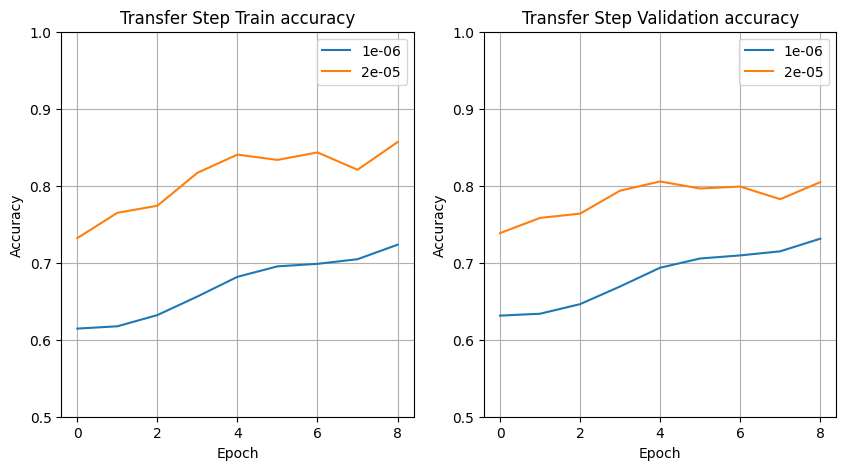

In [64]:
t_lr_train_acc = np.zeros((9, 2))
t_lr_dev_acc = np.zeros((9, 2))
for i in range(2):
    t_lr_train_acc[:, i] = TANDA_model_lst[i*5]['t_train_acc']
    t_lr_dev_acc[:, i] = TANDA_model_lst[i*5]['t_dev_acc']

# plot the accuracies against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(t_lr_train_acc)
ax[0].set_title('Transfer Step Train accuracy')
ax[1].plot(t_lr_dev_acc)
ax[1].set_title('Transfer Step Validation accuracy')

# common features
for i in range(2):
    ax[i].legend(transfer_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_ylim([0.5,1])
    ax[i].grid()

plt.show()



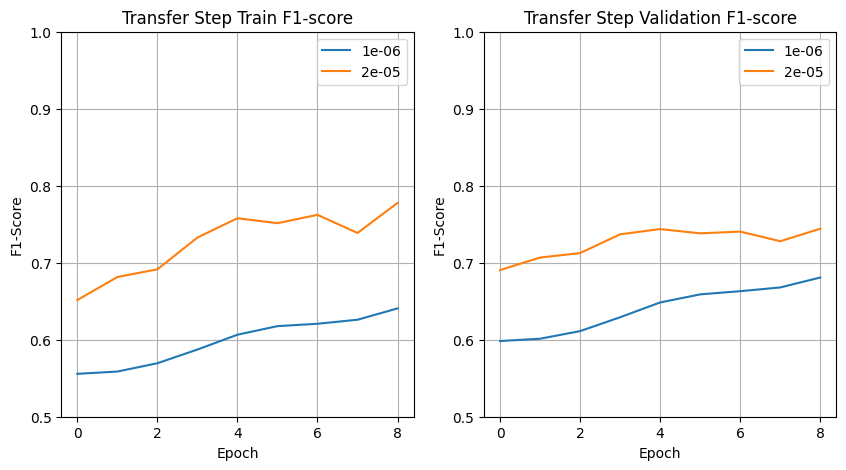

In [65]:
t_lr_train_f1 = np.zeros((9, 2))
t_lr_dev_f1 = np.zeros((9, 2))
for i in range(2):
    t_lr_train_acc[:, i] = TANDA_model_lst[i*5]['t_train_f1']
    t_lr_dev_acc[:, i] = TANDA_model_lst[i*5]['t_dev_f1']

# plot the F1-scores against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(t_lr_train_acc)
ax[0].set_title('Transfer Step Train F1-score')
ax[1].plot(t_lr_dev_acc)
ax[1].set_title('Transfer Step Validation F1-score')

# common features
for i in range(2):
    ax[i].legend(transfer_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('F1-Score')
    ax[i].set_ylim([0.5,1])
    ax[i].grid()

plt.show()

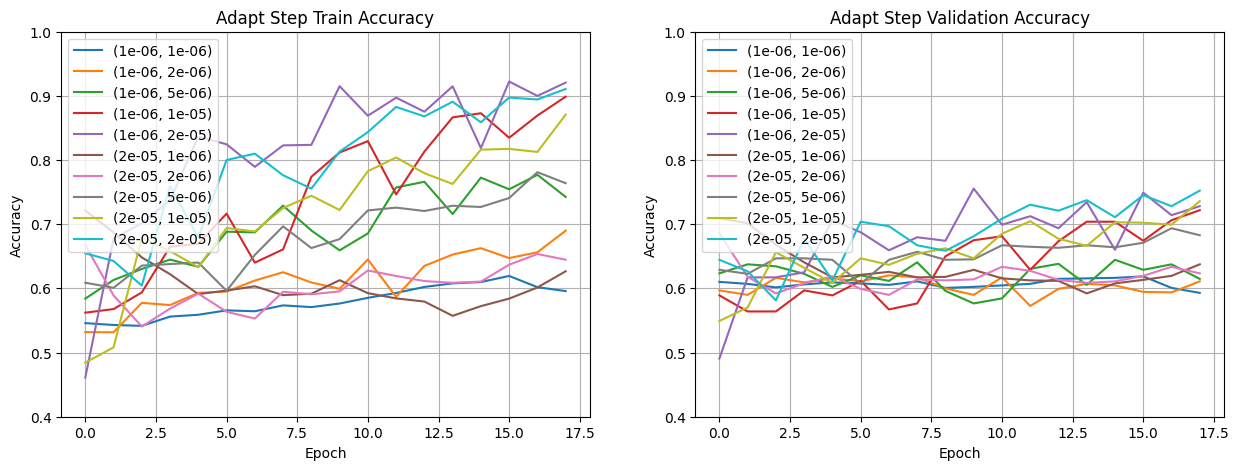

In [68]:
a_lr_train_acc = np.zeros((18, 10))
a_lr_dev_acc = np.zeros((18, 10))
t_a_lrs = []
for i in range(10):
    t_a_lrs.append((TANDA_model_lst[i]['t_lr'], TANDA_model_lst[i]['a_lr']))
    a_lr_train_acc[:, i] = TANDA_model_lst[i]['a_train_acc']
    a_lr_dev_acc[:, i] = TANDA_model_lst[i]['a_dev_acc']

# plot the accuracies against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(a_lr_train_acc)
ax[0].set_title('Adapt Step Train Accuracy')
ax[1].plot(a_lr_dev_acc)
ax[1].set_title('Adapt Step Validation Accuracy')

# common features
for i in range(2):
    ax[i].legend(t_a_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_ylim([0.4,1])
    ax[i].grid()

plt.show()

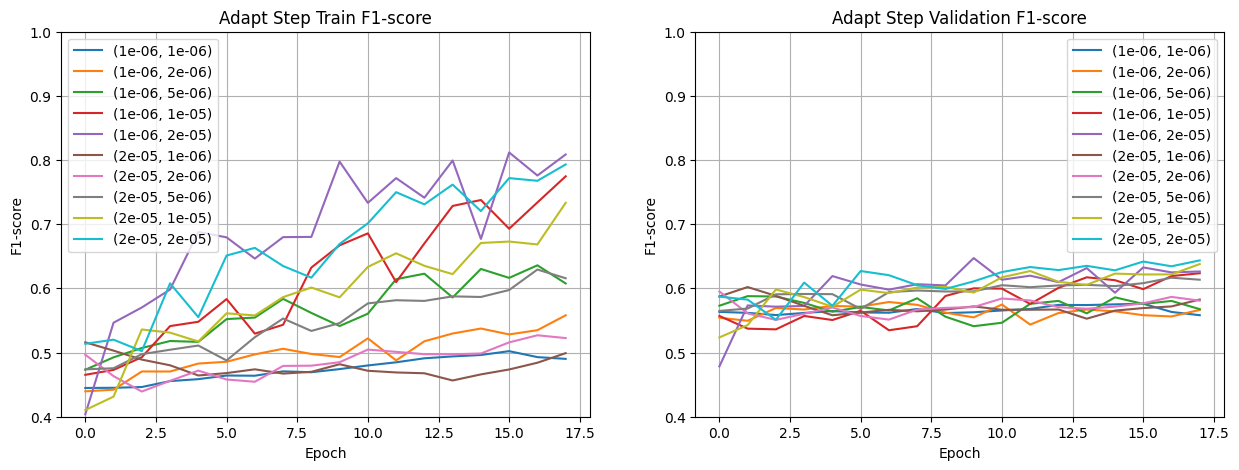

In [69]:
a_lr_train_f1 = np.zeros((18, 10))
a_lr_dev_f1 = np.zeros((18, 10))
t_a_lrs = []
for i in range(10):
    t_a_lrs.append((TANDA_model_lst[i]['t_lr'], TANDA_model_lst[i]['a_lr']))
    a_lr_train_acc[:, i] = TANDA_model_lst[i]['a_train_f1']
    a_lr_dev_acc[:, i] = TANDA_model_lst[i]['a_dev_f1']

# plot the F1-scores against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(a_lr_train_acc)
ax[0].set_title('Adapt Step Train F1-score')
ax[1].plot(a_lr_dev_acc)
ax[1].set_title('Adapt Step Validation F1-score')

# common features
for i in range(2):
    ax[i].legend(t_a_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('F1-score')
    ax[i].set_ylim([0.4,1])
    ax[i].grid()

plt.show()

In [47]:
# Create a new dataset that merges ANSQ and TREC-QA datasets
# training set
baseline_pretrain_train_dataset = QADataset(ANSQ_train_data + TREC_train_data, tokenizer)
# validation set
baseline_pretrain_val_dataset = QADataset(ANSQ_val_data + TREC_dev_data, tokenizer)



In [48]:
# Create baseline models by pretraining only the parameters in the newly added head
# on top of the base Transformer for QA pair classification with both ANSQ and TREC-QA datasets

# Pretrain classification head of baseline models with 5 different learning rates and 9 epochs each
baseline_lrs = [1e-6, 2e-6, 5e-6, 1e-5, 2e-5]
baseline_model_lst = []
for lr in baseline_lrs:
    # Initialize model, set baseline to true to prevent the parameters
    # of the pretrained base Transformer model from being updated in training
    QA_model = QATransformer(AutoModel.from_pretrained("prajjwal1/bert-mini"),
                             AutoConfig.from_pretrained("prajjwal1/bert-mini"),
                             baseline=True, num_labels=2)

    model_file_path = './Baseline_'+str(lr)+'.pt'
    # Pretrain the classification head
    print("Pretraining QA classification head with learning rate: %s"%str(lr))
    train_acc, train_f1, dev_acc, dev_f1 = train(QA_model, baseline_pretrain_train_dataset, baseline_pretrain_val_dataset,
                                                 batch_size=128, learning_rate=lr, num_of_epochs=9,
                                                 save_to_file=model_file_path)


    baseline_model_dict = {'lr':lr, 'baseline model':QA_model,
                'train_acc':train_acc, 'dev_acc':dev_acc,
                'train_f1':train_f1, 'dev_f1':dev_f1}
    baseline_model_lst.append(baseline_model_dict)

Pretraining QA classification head with learning rate: 1e-06


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.38it/s]


save the model to ./Baseline_1e-06.pt
epoch 0: train loss :: 1.337, train acc :: 0.872,             dev acc :: 0.812, train F1 :: 0.470, dev F1 :: 0.451


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


epoch 1: train loss :: 1.323, train acc :: 0.871,             dev acc :: 0.811, train F1 :: 0.475, dev F1 :: 0.455


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


epoch 2: train loss :: 1.312, train acc :: 0.867,             dev acc :: 0.810, train F1 :: 0.486, dev F1 :: 0.467


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.45it/s]


epoch 3: train loss :: 1.301, train acc :: 0.859,             dev acc :: 0.804, train F1 :: 0.509, dev F1 :: 0.492


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


epoch 4: train loss :: 1.292, train acc :: 0.842,             dev acc :: 0.794, train F1 :: 0.534, dev F1 :: 0.522


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.44it/s]


epoch 5: train loss :: 1.283, train acc :: 0.818,             dev acc :: 0.780, train F1 :: 0.555, dev F1 :: 0.554


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


epoch 6: train loss :: 1.274, train acc :: 0.787,             dev acc :: 0.760, train F1 :: 0.567, dev F1 :: 0.576


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.46it/s]


epoch 7: train loss :: 1.270, train acc :: 0.754,             dev acc :: 0.737, train F1 :: 0.573, dev F1 :: 0.590


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:14<00:00,  2.47it/s]


epoch 8: train loss :: 1.261, train acc :: 0.722,             dev acc :: 0.716, train F1 :: 0.571, dev F1 :: 0.598
Pretraining QA classification head with learning rate: 2e-06


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:14<00:00,  2.47it/s]


save the model to ./Baseline_2e-06.pt
epoch 0: train loss :: 1.301, train acc :: 0.131,             dev acc :: 0.188, train F1 :: 0.119, dev F1 :: 0.162


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.44it/s]


save the model to ./Baseline_2e-06.pt
epoch 1: train loss :: 1.290, train acc :: 0.137,             dev acc :: 0.194, train F1 :: 0.127, dev F1 :: 0.171


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.44it/s]


save the model to ./Baseline_2e-06.pt
epoch 2: train loss :: 1.283, train acc :: 0.159,             dev acc :: 0.210, train F1 :: 0.153, dev F1 :: 0.195


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.42it/s]


save the model to ./Baseline_2e-06.pt
epoch 3: train loss :: 1.275, train acc :: 0.241,             dev acc :: 0.289, train F1 :: 0.241, dev F1 :: 0.287


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.41it/s]


save the model to ./Baseline_2e-06.pt
epoch 4: train loss :: 1.267, train acc :: 0.347,             dev acc :: 0.394, train F1 :: 0.338, dev F1 :: 0.392


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_2e-06.pt
epoch 5: train loss :: 1.260, train acc :: 0.418,             dev acc :: 0.464, train F1 :: 0.396, dev F1 :: 0.454


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_2e-06.pt
epoch 6: train loss :: 1.255, train acc :: 0.463,             dev acc :: 0.505, train F1 :: 0.431, dev F1 :: 0.488


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_2e-06.pt
epoch 7: train loss :: 1.249, train acc :: 0.487,             dev acc :: 0.527, train F1 :: 0.450, dev F1 :: 0.507


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.40it/s]


save the model to ./Baseline_2e-06.pt
epoch 8: train loss :: 1.242, train acc :: 0.506,             dev acc :: 0.544, train F1 :: 0.464, dev F1 :: 0.520
Pretraining QA classification head with learning rate: 5e-06


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_5e-06.pt
epoch 0: train loss :: 1.378, train acc :: 0.537,             dev acc :: 0.495, train F1 :: 0.366, dev F1 :: 0.363


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.38it/s]


epoch 1: train loss :: 1.348, train acc :: 0.372,             dev acc :: 0.370, train F1 :: 0.322, dev F1 :: 0.340


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.38it/s]


epoch 2: train loss :: 1.326, train acc :: 0.242,             dev acc :: 0.275, train F1 :: 0.240, dev F1 :: 0.275


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


epoch 3: train loss :: 1.309, train acc :: 0.203,             dev acc :: 0.250, train F1 :: 0.203, dev F1 :: 0.246


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.38it/s]


epoch 4: train loss :: 1.294, train acc :: 0.223,             dev acc :: 0.271, train F1 :: 0.223, dev F1 :: 0.268


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


epoch 5: train loss :: 1.278, train acc :: 0.306,             dev acc :: 0.356, train F1 :: 0.303, dev F1 :: 0.356


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.41it/s]


epoch 6: train loss :: 1.263, train acc :: 0.405,             dev acc :: 0.452, train F1 :: 0.388, dev F1 :: 0.445


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.41it/s]


save the model to ./Baseline_5e-06.pt
epoch 7: train loss :: 1.249, train acc :: 0.472,             dev acc :: 0.511, train F1 :: 0.441, dev F1 :: 0.496


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


save the model to ./Baseline_5e-06.pt
epoch 8: train loss :: 1.236, train acc :: 0.507,             dev acc :: 0.544, train F1 :: 0.468, dev F1 :: 0.523
Pretraining QA classification head with learning rate: 1e-05


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


save the model to ./Baseline_1e-05.pt
epoch 0: train loss :: 1.319, train acc :: 0.190,             dev acc :: 0.240, train F1 :: 0.189, dev F1 :: 0.232


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.42it/s]


save the model to ./Baseline_1e-05.pt
epoch 1: train loss :: 1.286, train acc :: 0.289,             dev acc :: 0.335, train F1 :: 0.287, dev F1 :: 0.335


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


save the model to ./Baseline_1e-05.pt
epoch 2: train loss :: 1.254, train acc :: 0.476,             dev acc :: 0.514, train F1 :: 0.444, dev F1 :: 0.499


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_1e-05.pt
epoch 3: train loss :: 1.228, train acc :: 0.529,             dev acc :: 0.565, train F1 :: 0.486, dev F1 :: 0.544


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_1e-05.pt
epoch 4: train loss :: 1.205, train acc :: 0.554,             dev acc :: 0.589, train F1 :: 0.505, dev F1 :: 0.563


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.38it/s]


save the model to ./Baseline_1e-05.pt
epoch 5: train loss :: 1.185, train acc :: 0.565,             dev acc :: 0.600, train F1 :: 0.513, dev F1 :: 0.572


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.39it/s]


save the model to ./Baseline_1e-05.pt
epoch 6: train loss :: 1.169, train acc :: 0.572,             dev acc :: 0.606, train F1 :: 0.518, dev F1 :: 0.576


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:17<00:00,  2.40it/s]


save the model to ./Baseline_1e-05.pt
epoch 7: train loss :: 1.153, train acc :: 0.572,             dev acc :: 0.607, train F1 :: 0.518, dev F1 :: 0.576


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.41it/s]


save the model to ./Baseline_1e-05.pt
epoch 8: train loss :: 1.142, train acc :: 0.573,             dev acc :: 0.608, train F1 :: 0.519, dev F1 :: 0.576
Pretraining QA classification head with learning rate: 2e-05


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.45it/s]


save the model to ./Baseline_2e-05.pt
epoch 0: train loss :: 1.267, train acc :: 0.538,             dev acc :: 0.569, train F1 :: 0.485, dev F1 :: 0.539


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.42it/s]


save the model to ./Baseline_2e-05.pt
epoch 1: train loss :: 1.213, train acc :: 0.559,             dev acc :: 0.589, train F1 :: 0.507, dev F1 :: 0.559


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.44it/s]


save the model to ./Baseline_2e-05.pt
epoch 2: train loss :: 1.176, train acc :: 0.570,             dev acc :: 0.599, train F1 :: 0.516, dev F1 :: 0.567


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.45it/s]


epoch 3: train loss :: 1.149, train acc :: 0.565,             dev acc :: 0.596, train F1 :: 0.513, dev F1 :: 0.565


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.43it/s]


save the model to ./Baseline_2e-05.pt
epoch 4: train loss :: 1.128, train acc :: 0.571,             dev acc :: 0.601, train F1 :: 0.518, dev F1 :: 0.569


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.41it/s]


save the model to ./Baseline_2e-05.pt
epoch 5: train loss :: 1.112, train acc :: 0.575,             dev acc :: 0.605, train F1 :: 0.520, dev F1 :: 0.572


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.46it/s]


save the model to ./Baseline_2e-05.pt
epoch 6: train loss :: 1.100, train acc :: 0.578,             dev acc :: 0.608, train F1 :: 0.522, dev F1 :: 0.574


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:16<00:00,  2.43it/s]


save the model to ./Baseline_2e-05.pt
epoch 7: train loss :: 1.090, train acc :: 0.581,             dev acc :: 0.610, train F1 :: 0.524, dev F1 :: 0.576


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:15<00:00,  2.44it/s]


save the model to ./Baseline_2e-05.pt
epoch 8: train loss :: 1.083, train acc :: 0.582,             dev acc :: 0.612, train F1 :: 0.526, dev F1 :: 0.578


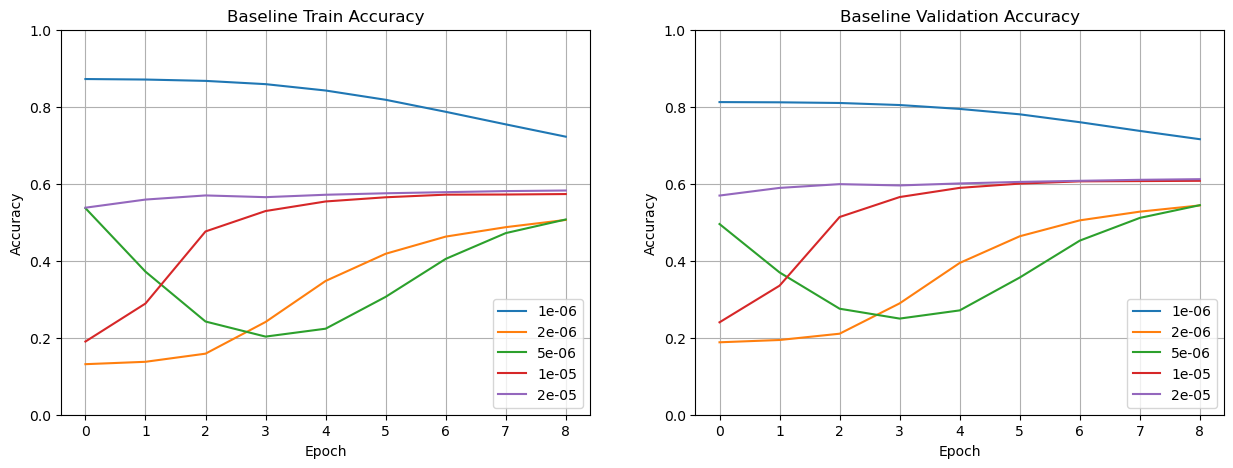

In [54]:
baseline_lr_train_acc = np.zeros((9, 5))
baseline_lr_dev_acc = np.zeros((9, 5))
for i in range(5):
    baseline_lr_train_acc[:, i] = baseline_model_lst[i]['train_acc']
    baseline_lr_dev_acc[:, i] = baseline_model_lst[i]['dev_acc']

# plot the accuracies against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(baseline_lr_train_acc)
ax[0].set_title('Baseline Train Accuracy')
ax[1].plot(baseline_lr_dev_acc)
ax[1].set_title('Baseline Validation Accuracy')

# common features
for i in range(2):
    ax[i].legend(baseline_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_ylim([0,1])
    ax[i].grid()

plt.show()

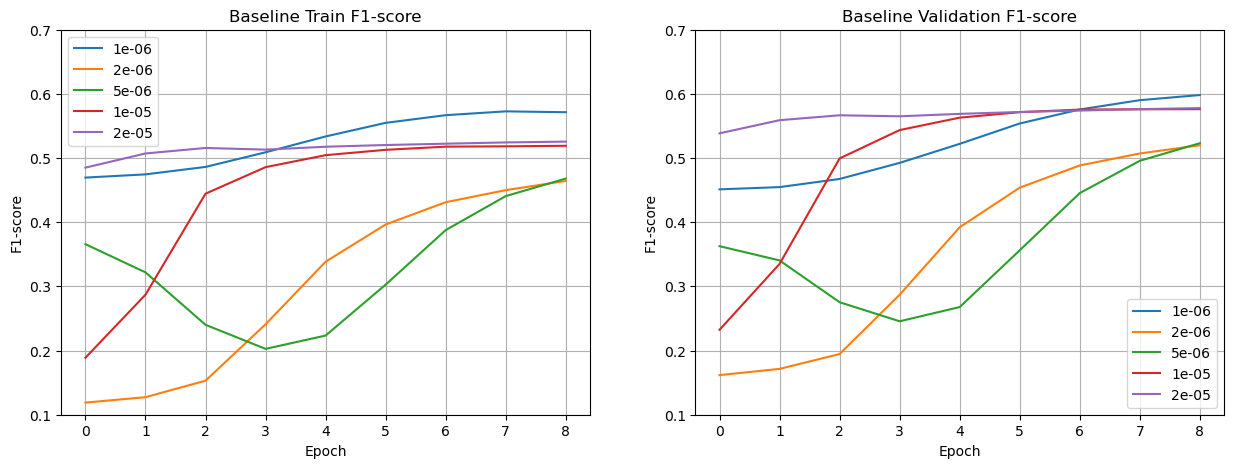

In [77]:
baseline_lr_train_f1 = np.zeros((9, 5))
baseline_lr_dev_f1 = np.zeros((9, 5))
for i in range(5):
    baseline_lr_train_f1[:, i] = baseline_model_lst[i]['train_f1']
    baseline_lr_dev_f1[:, i] = baseline_model_lst[i]['dev_f1']

# plot the F1-scores against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(baseline_lr_train_f1)
ax[0].set_title('Baseline Train F1-score')
ax[1].plot(baseline_lr_dev_f1)
ax[1].set_title('Baseline Validation F1-score')

# common features
for i in range(2):
    ax[i].legend(baseline_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('F1-score')
    ax[i].set_ylim([0.1,0.7])
    ax[i].grid()

plt.show()

In [59]:
# Create another set of models for comparison by pretraining only the parameters in the newly added head
# on top of the base Transformer for QA pair classification with both ANSQ and TREC-QA datasets

# Pretrain classification head of baseline models with 5 different learning rates and 9 epochs each
onestep_lrs = [1e-6, 2e-6, 5e-6, 1e-5, 2e-5]
onestep_model_lst = []
for lr in onestep_lrs:
    # Initialize model, set baseline to true to prevent the parameters
    # of the pretrained base Transformer model from being updated in training
    QA_model = QATransformer(AutoModel.from_pretrained("prajjwal1/bert-mini"),
                             AutoConfig.from_pretrained("prajjwal1/bert-mini"),
                             baseline=False, num_labels=2)

    model_file_path = './OneStep_'+str(lr)+'.pt'
    # Pretrain the classification head
    print("Performing one-step finetuning with learning rate: %s"%str(lr))
    train_acc, train_f1, dev_acc, dev_f1 = train(QA_model, baseline_pretrain_train_dataset, baseline_pretrain_val_dataset,
                                                 batch_size=128, learning_rate=lr, num_of_epochs=9,
                                                 save_to_file=model_file_path)


    onestep_model_dict = {'lr':lr, 'onestep model':QA_model,
                          'train_acc':train_acc, 'dev_acc':dev_acc,
                          'train_f1':train_f1, 'dev_f1':dev_f1}
    onestep_model_lst.append(onestep_model_dict)

Performing one-step finetuning with learning rate: 1e-06


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:44<00:00,  1.77it/s]


save the model to ./OneStep_1e-06.pt
epoch 0: train loss :: 1.236, train acc :: 0.549,             dev acc :: 0.582, train F1 :: 0.501, dev F1 :: 0.552


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.78it/s]


save the model to ./OneStep_1e-06.pt
epoch 1: train loss :: 1.115, train acc :: 0.584,             dev acc :: 0.616, train F1 :: 0.527, dev F1 :: 0.582


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:42<00:00,  1.80it/s]


save the model to ./OneStep_1e-06.pt
epoch 2: train loss :: 1.048, train acc :: 0.633,             dev acc :: 0.658, train F1 :: 0.564, dev F1 :: 0.618


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:42<00:00,  1.81it/s]


save the model to ./OneStep_1e-06.pt
epoch 3: train loss :: 1.010, train acc :: 0.679,             dev acc :: 0.696, train F1 :: 0.598, dev F1 :: 0.649


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.79it/s]


save the model to ./OneStep_1e-06.pt
epoch 4: train loss :: 0.988, train acc :: 0.690,             dev acc :: 0.704, train F1 :: 0.607, dev F1 :: 0.656


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.79it/s]


save the model to ./OneStep_1e-06.pt
epoch 5: train loss :: 0.976, train acc :: 0.694,             dev acc :: 0.705, train F1 :: 0.611, dev F1 :: 0.658


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.79it/s]


save the model to ./OneStep_1e-06.pt
epoch 6: train loss :: 0.967, train acc :: 0.703,             dev acc :: 0.713, train F1 :: 0.618, dev F1 :: 0.665


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:45<00:00,  1.76it/s]


save the model to ./OneStep_1e-06.pt
epoch 7: train loss :: 0.960, train acc :: 0.712,             dev acc :: 0.720, train F1 :: 0.626, dev F1 :: 0.671


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:44<00:00,  1.77it/s]


save the model to ./OneStep_1e-06.pt
epoch 8: train loss :: 0.952, train acc :: 0.724,             dev acc :: 0.729, train F1 :: 0.635, dev F1 :: 0.678
Performing one-step finetuning with learning rate: 2e-06


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:45<00:00,  1.75it/s]


save the model to ./OneStep_2e-06.pt
epoch 0: train loss :: 1.137, train acc :: 0.605,             dev acc :: 0.632, train F1 :: 0.544, dev F1 :: 0.596


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:44<00:00,  1.76it/s]


save the model to ./OneStep_2e-06.pt
epoch 1: train loss :: 1.012, train acc :: 0.680,             dev acc :: 0.693, train F1 :: 0.600, dev F1 :: 0.647


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:41<00:00,  1.83it/s]


save the model to ./OneStep_2e-06.pt
epoch 2: train loss :: 0.978, train acc :: 0.699,             dev acc :: 0.708, train F1 :: 0.615, dev F1 :: 0.661


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:42<00:00,  1.81it/s]


save the model to ./OneStep_2e-06.pt
epoch 3: train loss :: 0.960, train acc :: 0.712,             dev acc :: 0.718, train F1 :: 0.627, dev F1 :: 0.669


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.79it/s]


save the model to ./OneStep_2e-06.pt
epoch 4: train loss :: 0.946, train acc :: 0.734,             dev acc :: 0.735, train F1 :: 0.644, dev F1 :: 0.684


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:46<00:00,  1.74it/s]


save the model to ./OneStep_2e-06.pt
epoch 5: train loss :: 0.931, train acc :: 0.738,             dev acc :: 0.739, train F1 :: 0.649, dev F1 :: 0.687


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:45<00:00,  1.75it/s]


save the model to ./OneStep_2e-06.pt
epoch 6: train loss :: 0.923, train acc :: 0.740,             dev acc :: 0.740, train F1 :: 0.652, dev F1 :: 0.689


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.79it/s]


save the model to ./OneStep_2e-06.pt
epoch 7: train loss :: 0.913, train acc :: 0.753,             dev acc :: 0.750, train F1 :: 0.663, dev F1 :: 0.697


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:43<00:00,  1.78it/s]


save the model to ./OneStep_2e-06.pt
epoch 8: train loss :: 0.905, train acc :: 0.777,             dev acc :: 0.771, train F1 :: 0.683, dev F1 :: 0.713
Performing one-step finetuning with learning rate: 5e-06


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:45<00:00,  1.76it/s]


save the model to ./OneStep_5e-06.pt
epoch 0: train loss :: 1.083, train acc :: 0.707,             dev acc :: 0.715, train F1 :: 0.619, dev F1 :: 0.663


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:46<00:00,  1.74it/s]


save the model to ./OneStep_5e-06.pt
epoch 1: train loss :: 0.969, train acc :: 0.737,             dev acc :: 0.739, train F1 :: 0.646, dev F1 :: 0.686


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:45<00:00,  1.75it/s]


save the model to ./OneStep_5e-06.pt
epoch 2: train loss :: 0.934, train acc :: 0.736,             dev acc :: 0.741, train F1 :: 0.648, dev F1 :: 0.691


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:44<00:00,  1.76it/s]


save the model to ./OneStep_5e-06.pt
epoch 3: train loss :: 0.911, train acc :: 0.744,             dev acc :: 0.746, train F1 :: 0.656, dev F1 :: 0.695


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:46<00:00,  1.73it/s]


epoch 4: train loss :: 0.895, train acc :: 0.736,             dev acc :: 0.739, train F1 :: 0.651, dev F1 :: 0.691


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:47<00:00,  1.72it/s]


save the model to ./OneStep_5e-06.pt
epoch 5: train loss :: 0.882, train acc :: 0.781,             dev acc :: 0.774, train F1 :: 0.689, dev F1 :: 0.717


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:46<00:00,  1.74it/s]


save the model to ./OneStep_5e-06.pt
epoch 6: train loss :: 0.873, train acc :: 0.804,             dev acc :: 0.788, train F1 :: 0.710, dev F1 :: 0.728


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:46<00:00,  1.73it/s]


epoch 7: train loss :: 0.868, train acc :: 0.779,             dev acc :: 0.769, train F1 :: 0.689, dev F1 :: 0.716


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:45<00:00,  1.75it/s]


epoch 8: train loss :: 0.857, train acc :: 0.775,             dev acc :: 0.766, train F1 :: 0.686, dev F1 :: 0.714
Performing one-step finetuning with learning rate: 1e-05


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:50<00:00,  1.68it/s]


save the model to ./OneStep_1e-05.pt
epoch 0: train loss :: 1.041, train acc :: 0.721,             dev acc :: 0.728, train F1 :: 0.632, dev F1 :: 0.677


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:50<00:00,  1.67it/s]


save the model to ./OneStep_1e-05.pt
epoch 1: train loss :: 0.935, train acc :: 0.725,             dev acc :: 0.732, train F1 :: 0.640, dev F1 :: 0.684


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:49<00:00,  1.69it/s]


save the model to ./OneStep_1e-05.pt
epoch 2: train loss :: 0.905, train acc :: 0.783,             dev acc :: 0.773, train F1 :: 0.689, dev F1 :: 0.716


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:49<00:00,  1.69it/s]


save the model to ./OneStep_1e-05.pt
epoch 3: train loss :: 0.883, train acc :: 0.786,             dev acc :: 0.776, train F1 :: 0.695, dev F1 :: 0.720


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:49<00:00,  1.69it/s]


save the model to ./OneStep_1e-05.pt
epoch 4: train loss :: 0.867, train acc :: 0.793,             dev acc :: 0.777, train F1 :: 0.702, dev F1 :: 0.722


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:49<00:00,  1.68it/s]


save the model to ./OneStep_1e-05.pt
epoch 5: train loss :: 0.850, train acc :: 0.817,             dev acc :: 0.793, train F1 :: 0.727, dev F1 :: 0.734


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:48<00:00,  1.70it/s]


save the model to ./OneStep_1e-05.pt
epoch 6: train loss :: 0.835, train acc :: 0.838,             dev acc :: 0.807, train F1 :: 0.748, dev F1 :: 0.743


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:49<00:00,  1.68it/s]


epoch 7: train loss :: 0.821, train acc :: 0.818,             dev acc :: 0.788, train F1 :: 0.729, dev F1 :: 0.730


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:48<00:00,  1.70it/s]


epoch 8: train loss :: 0.813, train acc :: 0.818,             dev acc :: 0.788, train F1 :: 0.730, dev F1 :: 0.730
Performing one-step finetuning with learning rate: 2e-05


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:51<00:00,  1.66it/s]


save the model to ./OneStep_2e-05.pt
epoch 0: train loss :: 0.982, train acc :: 0.762,             dev acc :: 0.758, train F1 :: 0.669, dev F1 :: 0.703


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:48<00:00,  1.70it/s]


save the model to ./OneStep_2e-05.pt
epoch 1: train loss :: 0.901, train acc :: 0.786,             dev acc :: 0.773, train F1 :: 0.693, dev F1 :: 0.716


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:49<00:00,  1.69it/s]


epoch 2: train loss :: 0.866, train acc :: 0.776,             dev acc :: 0.762, train F1 :: 0.688, dev F1 :: 0.710


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:48<00:00,  1.71it/s]


epoch 3: train loss :: 0.840, train acc :: 0.783,             dev acc :: 0.764, train F1 :: 0.696, dev F1 :: 0.712


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:47<00:00,  1.72it/s]


save the model to ./OneStep_2e-05.pt
epoch 4: train loss :: 0.815, train acc :: 0.845,             dev acc :: 0.803, train F1 :: 0.757, dev F1 :: 0.740


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:52<00:00,  1.64it/s]


epoch 5: train loss :: 0.795, train acc :: 0.837,             dev acc :: 0.794, train F1 :: 0.750, dev F1 :: 0.734


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:51<00:00,  1.66it/s]


save the model to ./OneStep_2e-05.pt
epoch 6: train loss :: 0.777, train acc :: 0.855,             dev acc :: 0.804, train F1 :: 0.770, dev F1 :: 0.741


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:53<00:00,  1.63it/s]


save the model to ./OneStep_2e-05.pt
epoch 7: train loss :: 0.765, train acc :: 0.872,             dev acc :: 0.813, train F1 :: 0.791, dev F1 :: 0.746


eval: 100%|██████████████████████████████████████████████████████████████████████████| 185/185 [01:52<00:00,  1.64it/s]


save the model to ./OneStep_2e-05.pt
epoch 8: train loss :: 0.755, train acc :: 0.885,             dev acc :: 0.819, train F1 :: 0.806, dev F1 :: 0.750


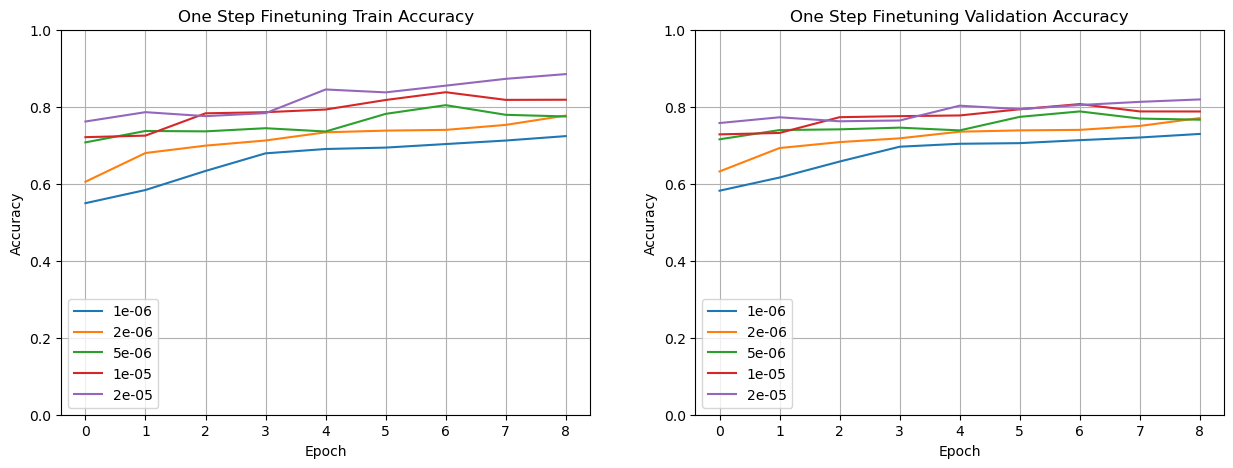

In [61]:
onestep_lr_train_acc = np.zeros((9, 5))
onestep_lr_dev_acc = np.zeros((9, 5))
for i in range(5):
    onestep_lr_train_acc[:, i] = onestep_model_lst[i]['train_acc']
    onestep_lr_dev_acc[:, i] = onestep_model_lst[i]['dev_acc']

# plot the accuracies against the number of epochs for different batch sizes
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(onestep_lr_train_acc)
ax[0].set_title('One Step Finetuning Train Accuracy')
ax[1].plot(onestep_lr_dev_acc)
ax[1].set_title('One Step Finetuning Validation Accuracy')

# common features
for i in range(2):
    ax[i].legend(onestep_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_ylim([0,1])
    ax[i].grid()

plt.show()

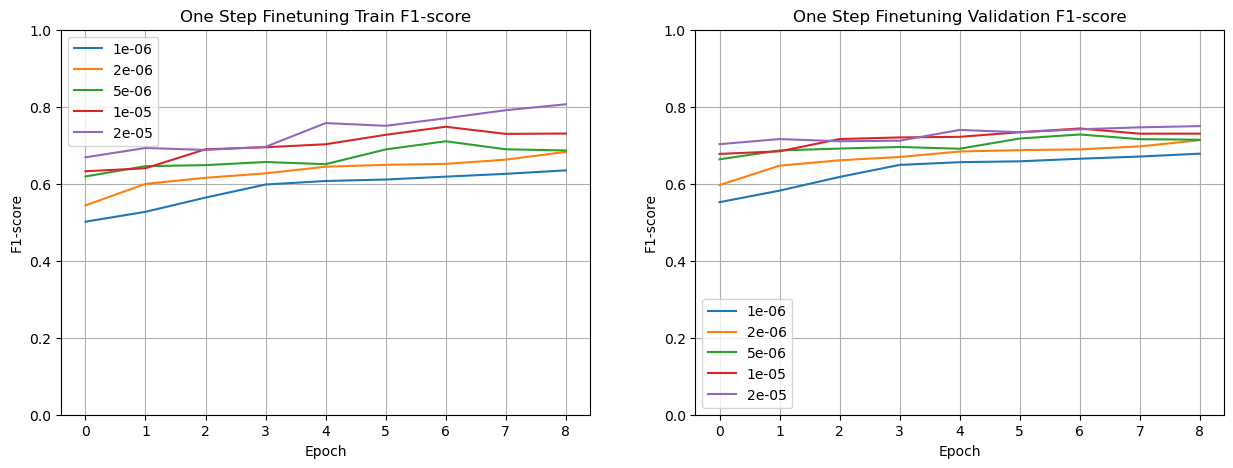

In [63]:
onestep_lr_train_f1 = np.zeros((9, 5))
onestep_lr_dev_f1 = np.zeros((9, 5))
for i in range(5):
    onestep_lr_train_f1[:, i] = onestep_model_lst[i]['train_f1']
    onestep_lr_dev_f1[:, i] = onestep_model_lst[i]['dev_f1']

# plot the F1-scores against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(onestep_lr_train_f1)
ax[0].set_title('One Step Finetuning Train F1-score')
ax[1].plot(onestep_lr_dev_f1)
ax[1].set_title('One Step Finetuning Validation F1-score')

# common features
for i in range(2):
    ax[i].legend(onestep_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('F1-score')
    ax[i].set_ylim([0,1])
    ax[i].grid()

plt.show()

## Final Model Evaluations

In [45]:
def test(QAmodel, test_dataset, batch_size):
    """
    Function to test QATransformer model's performance of a test dataset
    outputs the accuracy and F1-score of the QATransformer model on the test dataset
    """
    with torch.no_grad():
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        QAmodel = QAmodel.to(device)

        test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size,
                      collate_fn=test_dataset.collate_fn)

        test_acc, test_f1, *_ = model_eval(test_loader, QAmodel, device)
    return test_acc, test_f1

In [75]:
# As shown in the plots for the training and validation accuracies and F1-scores
# of the models after applying TANDA technique, the model transferred with 1e-6 lr
# and adapted with 2e-5 lr achieved the best performance on the 10th epoch

# Since the 10th epoch was not the last epoch of the adapt step, we need to load 
# the model from the .pt file where its info was saved in
saved = torch.load('TANDA_1e-06_2e-05.pt')
config = saved['model_config']
TANDA_model = QATransformer(AutoModel.from_pretrained("prajjwal1/bert-mini"),config['base_config'],
                            config['baseline'],config['num_labels'])
TANDA_model.load_state_dict(saved['model'])

<All keys matched successfully>

In [73]:
# As shown in the plots for the training and validation accuracies and F1-scores
# of the baseline models, the baseline model that trained the newly added classification head
# with 1e-6 lr achieved the best F1-score on the 9th epoch (the last epoch of training)

# Test the optimal baseline model with the TREC-QA test set
# The optimal baseline model and its info was saved at the first element of baseline_model_lst
baseline_performance = test(baseline_model_lst[0]['baseline model'], TREC_test_dataset, 128)
print("Performance of baseline Transformer model on TREC-QA test set: (Accuracy: %.3f, F1-score: %.3f)"%(baseline_performance[0],
                                                                                                         baseline_performance[1]))

eval: 100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.32it/s]

Performance of baseline Transformer model on TREC-QA test set: (Accuracy: 0.514, F1-score: 0.435)


In [74]:
# As shown in the plots for the training and validation accuracies and F1-scores
# of the one-step finetuned models, the one-step finetuned model that was finetuned
# with 2e-5 lr achieved the best F1-score on the 9th epoch (the last epoch of training)

# Test the optimal one-step finetuned model with the TREC-QA test set
# The optimal one-step finetuned model and its info was saved at the last (the 5th) element of baseline_model_lst
onestep_performance = test(onestep_model_lst[4]['onestep model'], TREC_test_dataset, 128)
print("Performance of Transformer model after one-step finetuning, on TREC-QA test set: (Accuracy: %.3f, F1-score: %.3f)"%(onestep_performance[0],
                                                                                                                           onestep_performance[1]))

eval: 100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.86it/s]

Performance of Transformer model after one-step finetuning, on TREC-QA test set: (Accuracy: 0.752, F1-score: 0.597)


In [79]:
# Test the optimal TANDA finetuned model with the TREC-QA test set
TANDA_performance = test(TANDA_model, TREC_test_dataset, 128)
print("Performance of Transformer model after TANDA, on TREC-QA test set: (Accuracy: %.3f, F1-score: %.3f)"%(TANDA_performance[0],
                                                                                                                      TANDA_performance[1]))

eval: 100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.49it/s]

Performance of Transformer model after TANDA, on TREC-QA test set: (Accuracy: 0.774, F1-score: 0.635)
